In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import gdal
import nivapy3 as nivapy
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Machine learning for image classification

Kasper has supplied some example images for the ImageDrone DigiSIS project - see e-mails received 07/03/2018 for details.

The aim of this notebook is to train a simple machine learning algorithm to automatically classify marine substrates. The main categories of interest are:

 * Sandy sediments
 * Eel grass
 * Brown seaweeds
 
We might also include "Fucus" here, although I've ignored this for now (see e-mail from Kapser received 07/03/2018 at 23:44).
 
In addition, based on a brief look at the images, I have defined the following additional categories:

 * Rock (terrestrial)
 * Beach (terrestrial)
 * Vegetation (terrestrial)
 
This second group is not of scientific interest, but it may nevertheless be useful to distinguish them explicitly.

## 1. Overview of raw data

The raw images are "geotagged" (but not georeferenced) JPGs. In other words, the metadata in the "Properties" for each image provides the latitude, longitude and altitude, but the image extent, pixel dimensions, warp etc. cannot be determined without further processing. Creating fully georeferenced images requires combining multiple JPGs and applying an orthographic correction. This can be done using e.g. [OpenDroneMap](http://opendronemap.org/) (see discussion with Kapser and Robert on 07/03/2018 for details), but for now I will focus on working with the "raw", unreferenced datasets. 

In practice, working with the raw data means defining a "false projection" for each image (WGS84 UTM Zone 32N in this case), but not actually performing any georeferencing i.e. each image appears at the "origin" of the UTM Zone 32N grid. In addition, it is more convenient to work with GeoTiffs than JPGs. The folder `'/gis/raster/geotiff_unproj'` therefore contains `.tif` versions of the raw JPGs, with the "false" co-ordinate system applied.

## 2. Manual classification

I need to create a reference dataset for training and evaluation of the ML algorithm. This is achieved by manually classifying a selection of images, and then using some of them for training and some for evaluation. In some cases, there will also be uncertainty regarding the manual classifications, but this is ignored in the analysis presented here: I'm assuming the manual classifications represent the "truth", and the ML algorithm is evaluated based on its ability to reproduce the manually assigned categories.  

Constructing a good classification algorithm requires a good training dataset, but for the preliminary exploration presented here I'm **going to focus on just three of the images** supplied by Kapser:

 * DJI_0388 
 * DJI_0389 
 * DJI_0399
 
The raw image named `'templateDJI_0388_characterized.jpg'` (provided by Kasper and shown below) gives examples of the main substrate categories under consideration. I have used this image to guide a more comprehensive classification of the three images listed above.

**Note:** I believe there is also a "ground truth" dataset, collected by manually checking the substrate at specific points from a boat. I do not yet have access to this data and so have not included it here, but it would probably help to refine/improve the training dataset.

<img src="../images/raw_drone_jpgs/templateDJI_0388_characterized.jpg" alt="Substrate examples" width="800" />

### 2.1. Manual classification workflow

Manual classification was performed using ArcGIS. I've created a geodatabase called `'drone_training_data.gdb'`, which includes a Coded Domain called `'substrate'` with the following classes:

| Code |      Substrate Class     |
|:----:|:------------------------:|
|  -1  |           Other          |
|   0  |          No data         |
|   1  |         Eel grass        |
|   2  |      Sandy sediment      |
|   3  |      Brown seaweeds      |
|   4  |           Fucus          |
|   5  |    Rock (terrestrial)    |
|   6  |    Beach (terrestrial)   |
|   7  | Vegetation (terrestrial) |

I have then created a feature dataset for the "unprojected" vector data (with the same "false" projection used by the GeoTiffs), and within this there is one feature class per image, each with the coded domain shown above assigned to the `'substrate'` field.

This setup makes it relatively easy to create a training dataset in ArcGIS, as illustrated by the screenshot below.

<img src="../images/arcgis_screenshot.png" alt="ArcGIS screenshot" width="1000" />

### 2.2. Rasterise vector training data

The vector feature classes must be rasterised with the same extent and pixel resolution as the underlying GeoTiffs. This is most easily achieved by exporting from the geodatabase as shapefiles and then using NivaPy.

In [2]:
# Class codes
class_codes = {-1:'Other',
               0: 'No data',
               1: 'Eel grass',
               2: 'Sandy sediment',
               3: 'Brown seaweeds', 
               4: 'Fucus',
               5: 'Rock (terrestrial)',
               6: 'Beach (terrestrial)',
               7: 'Vegetation (terrestrial)'}

# Use one of the raw images as a "snap raster"
snap_tif = r'../gis/raster/geotif_unproj/DJI_0388.tif'

# Image names
fnames = ['DJI_0388', 'DJI_0389', 'DJI_0399']

# Loop over shapefiles
for name in fnames:
    # Build path to shp
    shp_path = r'../gis/vector/%s.shp' % name
    
    # Build path to output tiff
    tif_path = r'../gis/raster/geotif_unproj/%s_manual.tif' % name
    
    # Rasterise
    nivapy.spatial.shp_to_ras(shp_path, tif_path, snap_tif, 'substrate', 
                              -1, gdal.GDT_Int16)

We can now visualise the raw images and the training data side-by-side.

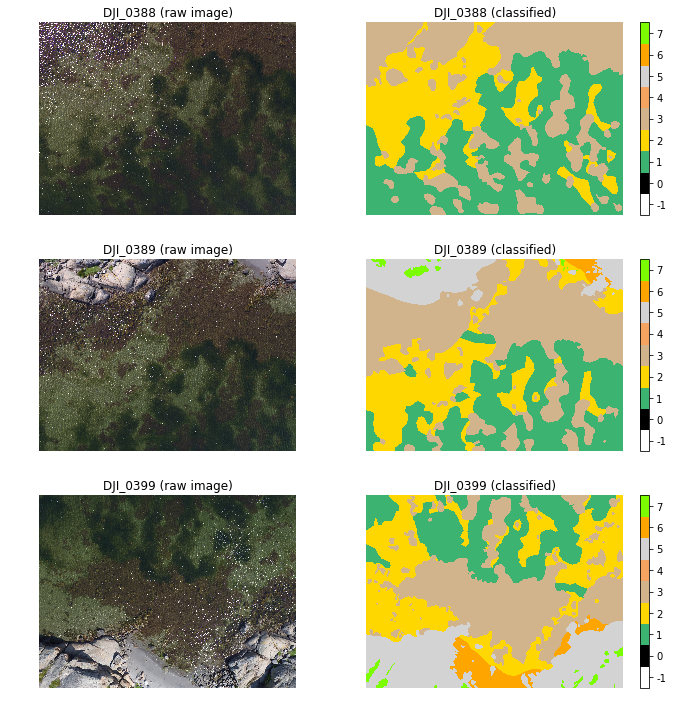

In [3]:
# Setup plot
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,10))

# Define colours for manual classes
cmap = colors.ListedColormap(['white', 'black', 'mediumseagreen', 'gold',
                              'tan', 'sandybrown', 'lightgrey', 'orange', 
                              'lawngreen'])
bounds = np.arange(-1.5, 8.5)
norm = colors.BoundaryNorm(bounds, cmap.N)

# Loop over data
for idx, name in enumerate(fnames):
    # Paths to images
    raw_path = r'../gis/raster/geotif_unproj/%s.tif' % name
    man_path = r'../gis/raster/geotif_unproj/%s_manual.tif' % name
    
    # Read raw bands to arrays
    band1, ndv, extent = nivapy.spatial.read_geotiff(raw_path, band=1)
    band2, ndv, extent = nivapy.spatial.read_geotiff(raw_path, band=2)
    band3, ndv, extent = nivapy.spatial.read_geotiff(raw_path, band=3)
    raw_img = np.dstack((band1, band2, band3))
    
    # Read manually classified data (1 band only)
    man_img, ndv, extent = nivapy.spatial.read_geotiff(man_path, band=1)
    
    # Plot
    # Raw image
    axes[idx, 0].imshow(raw_img)
    axes[idx, 0].set_title('%s (raw image)' % name, fontsize=12)
    
    # Manually classified
    img = axes[idx, 1].imshow(man_img, cmap=cmap, norm=norm)
    axes[idx, 1].set_title('%s (classified)' % name, fontsize=12)
    
    # Turn off axes
    axes[idx, 0].axis('off')
    axes[idx, 1].axis('off')
    
    # Colourbar for manual dataset
    cb = plt.colorbar(img, ax=axes[idx, 1])    
    labels = np.arange(-1, 8)
    cb.set_ticks(labels)
    cb.set_ticklabels(labels)
    
plt.tight_layout()

## 3. Training and evaluation datasets

I will take a standard ML approach and split the data into three portions: one for training, one for evaluation and a third for testing. This preliminary analysis will focus on pixel-based approaches, and each image is 4608 by 3456 pixels in size. We therefore have a total of $4608 \times 3456 \times 3 = 47.8 \; megapixels$ to work with. Each image consists of three bands (R, G, B), each of which will form an "explanatory variable". In ML terms, we therefore have a design matrix consisting of 47.8 million samples and three features. I will split this data as follows:

 * Data from the first two images (`'DJI_0388'` and `'DJI_0389'`) will be pooled, and then split 60:40 at random to create the training and evaluation datasets, respectively. These datasets will have the following sizes:
 
$$Training: \qquad 0.6 \times 4608 \times 3456 \times 2 = 19.1 \; million \; samples$$

$$Evaluation: \qquad 0.4 \times 4608 \times 3456 \times 2 = 12.7 \; million \; samples$$

  * The thrid image, `'DJI_0399'`, is withheld as a completely independent image for testing the fitted algorithm at the end of the process (see section 5, below).
  
**Note:** These three images are not entirely independent - there is substantial overlap between them. In fact, image 3 is approximately the same as image 2, just rotated by 180 degrees (see above). The testing procedure would be more robust if it applied to entirely separate images (e.g. from a different area and/or under different lightling conditions). This needs exploring eventually, but is not considered here. 

In [ ]:
# Containers for data
y_list = []
r_list = []
g_list = []
b_list = []

# Loop over data for images 1 and 2
for name in fnames[:2]:
    # Paths to images
    raw_path = r'../gis/raster/geotif_unproj/%s.tif' % name
    man_path = r'../gis/raster/geotif_unproj/%s_manual.tif' % name
    
    # Read raw bands to arrays
    band1, ndv, extent = nivapy.spatial.read_geotiff(raw_path, band=1)
    band2, ndv, extent = nivapy.spatial.read_geotiff(raw_path, band=2)
    band3, ndv, extent = nivapy.spatial.read_geotiff(raw_path, band=3)
    
    # Read manually classified data (1 band only)
    man_img, ndv, extent = nivapy.spatial.read_geotiff(man_path, band=1)
    
    # Flatten to 1D and append
    y_list.append(man_img.flatten())
    r_list.append(band1.flatten())
    g_list.append(band2.flatten())
    b_list.append(band3.flatten())
    
# Concatenate to single dataset
y = np.concatenate(y_list)
r = np.concatenate(r_list)
g = np.concatenate(g_list)
b = np.concatenate(b_list)

# Build df
df = pd.DataFrame({'y':y,
                   'r':r,
                   'g':g,
                   'b':b})

# Some values are "No data" due to edge effects. Remove these
df = df.query('y > 0')

# Split into training and evaluation
X_train, X_eval, y_train, y_eval = train_test_split(df[['r', 'g', 'b']],
                                                    df['y'],
                                                    test_size=0.4,
                                                    random_state=42)

# Checking
assert len(X_train) == len(y_train)
assert len(X_eval) == len(y_eval)
print('Number of training samples:  ', len(X_train))
print('Number of evaluation samples:', len(X_eval))

## 4. Train and evaluate classifier

We will begin with a Random Forest Classifier, which is relatively easy to implement and has some nice properties (such as providing class probabilities for each pixel).

### 4.1. Training and prediction

In [ ]:
%%time

# Fit classifier to training data
classifier = RandomForestClassifier(n_jobs=-1)
classifier.fit(X_train, y_train)

In [ ]:
%%time

# Predict classes for remaining 40% of data
preds = classifier.predict(X_eval)

With more than 19 million samples, it takes quite a long time (~4.5 minutes) to train the classifier. However, once trained, making predictions is relatively fast (~20 seconds).

### 4.2. Evaluation

In [ ]:
# Only use relevant labels from the training dataset
class_labels = [1, 2, 3, 5, 6, 7]
target_names = [class_codes[i] for i in class_labels]

# Print metrics
print("Classification report:\n%s" %
      metrics.classification_report(y_eval, preds, 
                                    labels=class_labels, 
                                    target_names=target_names))

print("Classification accuracy: %f" %
      metrics.accuracy_score(y_eval, preds))

To understand the table above, the following definitions may be helpful (taken from [here](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html)):

Precision ($P$) is defined as the number of true positives ($T_p$) over the number of true positives plus the number of false positives ($F_p$)

$$P = \frac{T_p}{T_p+F_p}$$

Intuitively, **precision** is the ability of the classifier **not to label as positive a sample that is negative**.

Recall ($R$) is defined as the number of true positives ($T_p$) over the number of true positives plus the number of false negatives ($F_n$)

$$R = \frac{T_p}{T_p + F_n}$$

Intuitively, **recall** is the ability of the classifier **to find all the positive samples**.

These quantities are also related to the $F_1$ score, which is defined as the harmonic mean of precision and recall

$$F1 = 2\frac{P \times R}{P+R}$$

For each class, it gives an overall indication of performance, where precision and recall are weighted equally (see [here](https://en.wikipedia.org/wiki/F1_score) for more details).

The overall classification accuracy is around 84% (i.e. 84% of the pixels in the evaluation dataset are classified correctly). From the $F_1$ scores, we see that "Eel grass" and "Brown seaweeds" are classified especially well - probably because they are the most common categories in the dataset (the `'support'` column in the table above gives the number of pixels for each class). "Sandy sediment" is less reliably classified, but still not bad. Terrestrial vegetation and beach areas are not well classified at all, but this is likely because the categories are under-represented in the training dataset.

The **confusion matrix** provides further information.

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',
                          cmap='coolwarm'):
    """ Plots the confusion matrix.
    
        Normalization can be applied by setting `normalize=True`.
        
        From:
        
        http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    import itertools
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(shrink=0.6)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
# Congusion matrix    
fig = plt.figure(figsize=(8,8))
fig.add_subplot(111)
cm = metrics.confusion_matrix(y_eval, preds)
plot_confusion_matrix(cm, classes=target_names, normalize=True)

The values along the diagonal in a normalised confusion are the same as the "Recall" scores in the classification report above. The matrix should be read one row at a time: for example, the first row indicates that 86% of the true "Eel grass" pixels were correctly identified, but 9% were classified as "Sandy sediment" and 5% as "Brown seaweeds". In general, the algorithm is able to confidently identify the three main classes of interest, and the greatest confusion is associated with terrestrial vegetation, which is frequently mis-classified as "Sandy sediment".

## 5. Predictions with a test image

Next, the trained algorithm is presented with a new image (`'DJI_0399'`) and used to create a categorical map. This map can be compared to the manually classified version to get an impression of the algorithm's practical (rather than statistical) performance.

In [ ]:
# Get image name
name = fnames[-1]

# Paths to images
raw_path = r'../gis/raster/geotif_unproj/%s.tif' % name
man_path = r'../gis/raster/geotif_unproj/%s_manual.tif' % name
    
# Read raw bands to arrays
band1, ndv, extent = nivapy.spatial.read_geotiff(raw_path, band=1)
band2, ndv, extent = nivapy.spatial.read_geotiff(raw_path, band=2)
band3, ndv, extent = nivapy.spatial.read_geotiff(raw_path, band=3)

# Read manually classified data (1 band only)
man_img, ndv, extent = nivapy.spatial.read_geotiff(man_path, band=1)
    
# Build df
df = pd.DataFrame({'r':band1.flatten(),
                   'g':band2.flatten(),
                   'b':band3.flatten()})

# Predict classes for new image
pred_img = classifier.predict(df[['r', 'g', 'b']]).reshape(man_img.shape)

# Print metrics

# The training dataset only includes some of the possible labels
# Extract these for now
class_labels = [-1, 1, 2, 3, 5, 6, 7]
target_names = [class_codes[i] for i in class_labels]

print("Classification report:\n%s" %
      metrics.classification_report(man_img.flatten(), 
                                    pred_img.flatten(), 
                                    labels=class_labels, 
                                    target_names=target_names))

print("Classification accuracy: %f" %
      metrics.accuracy_score(man_img.flatten(), pred_img.flatten()))

# Congusion matrix    
fig = plt.figure(figsize=(8,8))
fig.add_subplot(111)
cm = metrics.confusion_matrix(man_img.flatten(), pred_img.flatten())
plot_confusion_matrix(cm, normalize=True, classes=target_names)

In [ ]:
# Plot results
# Setup plot
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8,12))
   
# Stack bands
raw_img = np.dstack((band1, band2, band3))

# Raw image
axes[0].imshow(raw_img)
axes[0].set_title('%s (raw image)' % name, fontsize=12)

# Manually classified
mimg = axes[1].imshow(man_img, cmap=cmap, norm=norm)
axes[1].set_title('%s (manual)' % name, fontsize=12)

# Predicted
aimg = axes[2].imshow(pred_img, cmap=cmap, norm=norm)
axes[2].set_title('%s (algorithm)' % name, fontsize=12)

# Turn off axes
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')

# Colourbar for manual dataset
mcb = plt.colorbar(mimg, ax=axes[1])    
labels = np.arange(-1, 8)
mcb.set_ticks(labels)
mcb.set_ticklabels(labels)

# Colourbar for manual dataset
acb = plt.colorbar(aimg, ax=axes[2])    
labels = np.arange(-1, 8)
acb.set_ticks(labels)
acb.set_ticklabels(labels)
    
plt.tight_layout()

For an initial attempt, I'd say these results are fairly promising. The automatically generated map is certainly similar to the manually classified version, though it's also obvious that some regionalisation/object segmentation would be beneficial.

$F_1$ scores for the three main categories of interest are around 71% to 72%, which is reasonable as a starting point given the very limited training dataset. It is evident from the confusion matrix that the algorithm is not yet capable of confidently identifying sandy sediments and brown seaweeds, so incorporating more data on these categories would be a good idea.

One issue that can easily be corrected is that ArcGIS has a minor bug, which leads to slight misalignments between vector and raster datasets. This results in a single row of "No data" cells along the margin of the predicted image, and these cells cannot be classified because the algorithm has never seen "No data" pixels before. This is the explanation for the "Other" column in the summary results above (with a `'support'` of 3456 - exactly one row of pixels). This has a negative impact on the predictive ability of the algorithm, and should be removed.

## 6. Apply to larger image

**Updated 27/08/2018**

Kasper has a much larger mosiacked image that he would like to try and classify. 

### 6.1. Re-train random forest

Further refining and testing will be necessary, but for now we just want to apply the classification algorithm to a larger (unknown) image. It will also be interesting to see whether Jupyter can handle the full masaic in a single operation. 

The preliminary tests above indicate the general approach is promising, so I'll start by simply retraining the algorithm using all three manually classified images. This should produce a slightly more robust classifier. Note that the `'test_size'` in the code below is 0. I am not going to do any formal evaluation here - I just want to build the best random forest classifier I can using all the available training data. I'll then apply this to a completely new (and much larger) mosaicked image to see what happens. Although not very rigorous, it will be interesting to perform a qualitative visual assessment of results for the mosaicked image. 

In [4]:
# Containers for data
y_list = []
r_list = []
g_list = []
b_list = []

# Loop over data for images 1, 2 and 3
for name in fnames:
    # Paths to images
    raw_path = r'../gis/raster/geotif_unproj/%s.tif' % name
    man_path = r'../gis/raster/geotif_unproj/%s_manual.tif' % name
    
    # Read raw bands to arrays
    band1, ndv, extent = nivapy.spatial.read_geotiff(raw_path, band=1)
    band2, ndv, extent = nivapy.spatial.read_geotiff(raw_path, band=2)
    band3, ndv, extent = nivapy.spatial.read_geotiff(raw_path, band=3)
    
    # Read manually classified data (1 band only)
    man_img, ndv, extent = nivapy.spatial.read_geotiff(man_path, band=1)
    
    # Flatten to 1D and append
    y_list.append(man_img.flatten())
    r_list.append(band1.flatten())
    g_list.append(band2.flatten())
    b_list.append(band3.flatten())
    
# Concatenate to single dataset
y = np.concatenate(y_list)
r = np.concatenate(r_list)
g = np.concatenate(g_list)
b = np.concatenate(b_list)

# Build df
df = pd.DataFrame({'y':y,
                   'r':r,
                   'g':g,
                   'b':b})

# Some values are "No data" due to edge effects. Remove these
df = df.query('y > 0')

# Split into training and evaluation
X_train, X_eval, y_train, y_eval = train_test_split(df[['r', 'g', 'b']],
                                                    df['y'],
                                                    test_size=0,
                                                    random_state=42)

# Checking
assert len(X_train) == len(y_train)
assert len(X_eval) == len(y_eval)
print('Number of training samples:  ', len(X_train))
print('Number of evaluation samples:', len(X_eval))

Number of training samples:   47765376
Number of evaluation samples: 0


In [5]:
%%time

# Fit classifier to training data
classifier = RandomForestClassifier(n_jobs=-1)
classifier.fit(X_train, y_train)

Wall time: 10min 40s


### 6.2. Predictions for mosaiced image

In [6]:
%%time

# Path to image
raw_path = r'../gis/raster/geotif_mosaic/Olberg_RBG1og2_45_v3224m_transparent_mosaic_group1.tif'
  
# Read raw bands to arrays
band1, ndv, extent = nivapy.spatial.read_geotiff(raw_path, band=1)
band2, ndv, extent = nivapy.spatial.read_geotiff(raw_path, band=2)
band3, ndv, extent = nivapy.spatial.read_geotiff(raw_path, band=3)
   
# Build df
df = pd.DataFrame({'r':band1.flatten(),
                   'g':band2.flatten(),
                   'b':band3.flatten()})

# Predict classes for new image
#pred_img = classifier.predict(df[['r', 'g', 'b']]).reshape(band1.shape)

Wall time: 2min 25s


#### 6.2.1. For small images (< 100 MB?)

In [ ]:
# Predict classes for new image
#pred_img = classifier.predict(df[['r', 'g', 'b']]).reshape(band1.shape)

#### 6.2.2. For large images (> 100 MB?)

It is necessary to "chunk" the data, and take more care of dtypes.

In [21]:
# Container for data
df_list = []

# Process in "chunks" of 1E7 pixels
for g, df2 in df.groupby(np.arange(len(df)) // 1E7):
    pred_img = classifier.predict(df2[['r', 'g', 'b']]).astype(np.uint8)
    df_list.append(pred_img)

# Combine chunks
pred_img = np.concatenate(df_list, axis=0)

# Tidy
del df_list, df

# Reshape
pred_img = pred_img.reshape(band1.shape)

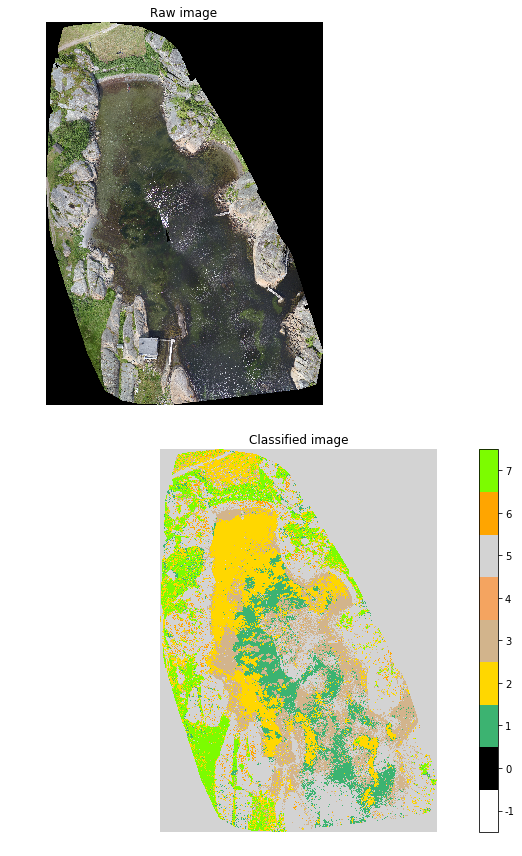

In [23]:
# Plot results
# Setup plot
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,12))
   
# Stack bands
raw_img = np.dstack((band1, band2, band3))

# Raw image
axes[0].imshow(raw_img)
axes[0].set_title('Raw image', fontsize=12)

# Predicted
aimg = axes[1].imshow(pred_img, cmap=cmap, norm=norm)
axes[1].set_title('Classified image', fontsize=12)

# Turn off axes
axes[0].axis('off')
axes[1].axis('off')

# Colourbar for manual dataset
acb = plt.colorbar(aimg, ax=axes[1])    
labels = np.arange(-1, 8)
acb.set_ticks(labels)
acb.set_ticklabels(labels)
    
plt.tight_layout()

out_path = r'../images/olberg_all.png'
plt.savefig(out_path, dpi=300)

## 7. Next steps

 * **Expand and improve the training dataset** (more varied light conditions, other categories of interest etc.). Also make use of the "ground truth" data from the boat
 
 * **Georeference, align and resample all images**, so that we can incorporate information from other spectral bands, not just (R, G, B)
 
 * **Try a range of classifiers/algorithms**
 
 * **Try image segmentation/OBIA**